# Real-time optimization with Modifier Adapation using Gaussian Processes
# CCTA - 2021
For each rto cycle consisting of 60 iterations, the process starts at a random feasible operating point around `u = [10.6521, 0.0005141, 224.4806]`, where 5 random operating points are also chosen for initialization of the Gaussian Process estimator. A gaussian noise of `0.01%` was added to the plant measurements. This was executed 30 times for each optimization algorithm evaluated. 



In [2]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import matplotlib.font_manager
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

from rto.experiment.data_model import RTODataModel
from rto.models.utils import build_F
from rto.models.semi_batch import SemiBatchReactor

# Replace this with your actual db path
md_exact_slsqp = RTODataModel('/mnt/d/rto_data/rto_poc_sqp_experiments.db')
md_debest = RTODataModel('/mnt/d/rto_data/rto_poc_de_experiments.db')

# The real plant optimum
# Load the real model to generate samples
model_ideal = SemiBatchReactor()
u_plant = [18.4427644, 0.00110823777, 227.792418]
f_plant = -0.5085930760109818


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [3]:
# Now, let's load the results data
# Then load the results
all_results_exact_klast = pd.DataFrame(md_exact_slsqp.get_rto_experiment_results('ma-gp-slsqp_scipy-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
all_results_debest1bin_klast = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])

In [4]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
# Define a helper function to perform the calculations
def pre_process_results(all_results):
    # Transform the data
    all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration','rto.type','run.status'], columns=['var_name'], aggfunc=aggfunc)
    all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)
    
    # remove the suffix
    all_results_pv['rto.type'] = all_results_pv['rto.type'].apply(lambda x: x.split('-')[2])

    # Convert the values
    all_results_pv[['cost_model','cost_real','fobj_modifier', 'opt_time']] = all_results_pv[['cost_model','cost_real','fobj_modifier','opt_time']].astype('float')

    # Extract some variables
    all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

    all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

    # kpis
    all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_plant)/u_plant), axis=1)
    all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * np.abs((x - f_plant)/f_plant))
    all_results_pv['g_Cb_tf'] = all_results_pv['g_0'].apply(lambda x: 'Not violated' if x <= 0.025 else 'Violated')
    all_results_pv['g_Cd_tf'] = all_results_pv['g_1'].apply(lambda x: 'Not violated' if x <= 0.15 else 'Violated')


    return all_results_pv

In [5]:
# Now apply the transformation
results_exact_klast = pre_process_results(all_results_exact_klast)
results_best1bin_klast = pre_process_results(all_results_debest1bin_klast)

results_exact_klast['rto.type'] = 'SQP'
results_best1bin_klast['rto.type'] = 'DE'

# Join the as a single dataframe
results_all = pd.concat([results_exact_klast, results_best1bin_klast], ignore_index=True)

## Results

In [7]:
# helper function for plotting
def plot_results(data, y, ylabel, title='', x='iteration', hue='rto.type', style='run.status', estimator=np.mean, ci=95, save=False, err_style='band'):
    width = 5.1667
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    sns.lineplot(data=data, y=y, x=x, style=hue, hue=hue, ax=ax, estimator=estimator, ci=ci, err_style=err_style, palette='Set1', seed=1234, legend=True, dashes=[(1, 1),(3, 3)])
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.get_legend().set_title('')

    if save == True:
        fig.savefig('fig_{}.pdf'.format(y), dpi=300)

    return ax, fig

def plot_all_input_signals(data, ylabel = 'F (mol / L)', y = ['tm','Fs','ts'], hue='rto.type', title='', save=False):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    data_grouped = data_last_iteration.groupby(hue)

    width = 5.1667
    height = width / 1.618
    # Opt results
    sim_opt = model_ideal.simulate(u_plant)    
    F_opt = build_F(sim_opt.t, u_plant)

    fig, ax = plt.subplots(1, len(data_grouped.groups), figsize=(width, height), sharey=True)    

    i = 0
    names = ['DE', 'SQP']
    for name, group in data_grouped:
        
        # find max cost index
        u_mean = group[y].mean()
        ax[i].set_xlabel('Time (min)')
        if(i == 0):
            ax[i].set_ylabel(ylabel)    
        ax[i].set_title(names[i])
        for j in range(group.shape[0]):
            F_i = build_F(sim_opt.t,  group[y].iloc[j,:]) 
            line1, = ax[i].plot(sim_opt.t, F_i, color='#e41a1c', linewidth='1', alpha=0.8, linestyle='dashed')

        line2, = ax[i].plot(sim_opt.t, F_opt, 'k-', lw=2)
        if (i==1):
            ax[i].legend((line2, line1), ('Optimum','k-$th$ experiment'))
        
        i = i + 1
    if save == True:
        fig.savefig('fig_F(t).pdf', dpi=300)



In [8]:
# plot the cost distribution at the last iteration
def plot_last_iteration_dist(data, ylabel = '', y = 'dPhi', hue='rto.type', title=''):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    
    width = 5.1667
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    
    sns.histplot(data_last_iteration, x=y, hue=hue, kde=True, ax=ax, palette='Set1')

    ax.set_xlabel(ylabel)
    ax.set_title(title)
    fig.show()

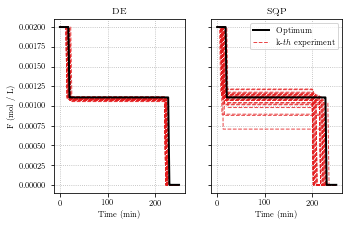

In [9]:
plot_all_input_signals(results_all, save=False)

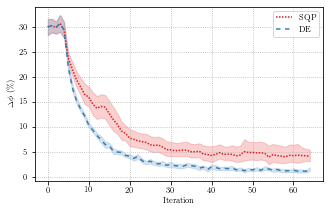

In [11]:
# Plot the convergence results for dPhi
ax, fig = plot_results(results_all, 'dPhi', '$\Delta \phi$ (\%)')
fig.show()

,mean
rto.type,
DE,5.159776
SQP,1.016814


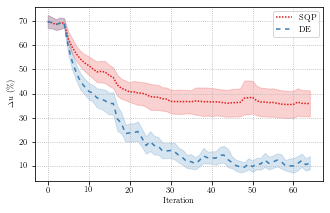

In [12]:
# Plot the convergence results for the input signal difference
display(results_all.groupby(['rto.type'])['opt_time'].agg(['mean']))

ax, fig = plot_results(results_all, 'du', '$\Delta u$ (\%)')
fig.show()
